In [1]:
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/fritt/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
df = pd.read_csv("data/quotes-2020-apple-filter.csv",sep=";")
df = df.append(pd.read_csv("data/quotes-2019-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2018-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2017-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2016-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2015-apple-filter.csv",sep=";"))

In [3]:
df.head()

,quoteID,quotation,speaker,date,numOccurrences
0,2020-03-29-000118,... Zane Lowe checks in via FaceTime with Elto...,None,2020-03-29 17:47:52,1
1,2020-02-13-007205,Apple prices generally peak in January. Betwee...,Sarah Johnson,2020-02-13 10:01:48,3
2,2020-01-23-044076,"I'm not sure why Apple did this,",Roger Grimes,2020-01-23 17:15:24,2
3,2020-01-02-039024,new multi-year license agreement under which A...,None,2020-01-02 09:56:04,3
4,2020-01-19-037883,the best sort of deal they could have come up ...,Dickie Arbiter,2020-01-19 19:24:59,1


**Changing the dataframe columns to their appropriate data types.**

In [4]:
df.quoteID = df.quoteID.astype('string')
df.quotation = df.quotation.astype('string')
df.speaker = df.speaker.astype('string')
df.numOccurrences = df.numOccurrences.astype('int32')

In [5]:
df.dtypes

quoteID           string
quotation         string
speaker           string
date              object
numOccurrences     int32
dtype: object

In [6]:
df = df.sort_values('date')
df.head()

,quoteID,quotation,speaker,date,numOccurrences
14360,2015-01-01-041284,With major new premium services from Apple and...,Geoff Taylor,2015-01-01 00:01:00,3
6973,2015-01-01-032875,They realize that they just can't assume that ...,Angus King,2015-01-01 00:14:24,1
12169,2015-01-01-036563,We feel that there are a substantial number of...,William Anderson,2015-01-01 01:30:18,1
9527,2015-01-01-041777,You can play a murderer's row but in conferenc...,Jim Crews,2015-01-01 02:47:17,1
19317,2015-01-01-039665,"We've also, surprisingly, had a lot of Apple r...",Daniel Williams,2015-01-01 04:10:31,1


In [7]:
column_names = ['quoteID', 'quotation', 'speaker', 'date', 'numOccurrences','neg', 'neu', 'pos', 'compound']
    
sentiment_info_df = pd.DataFrame(columns = column_names)

print("Total number of rows: ", df.shape[0])
for idx, row in tqdm(df.iterrows()):
    
    # Calculating scores from SentimentIntensityAnalyzer
    new_row_dct = SentimentIntensityAnalyzer().polarity_scores(row['quotation'])
    
    # Creating and writing over value    
    new_row_dct['quoteID'] = row['quoteID']
    new_row_dct['quotation'] = row['quotation']
    new_row_dct['speaker'] = row['speaker']
    new_row_dct['date'] = row['date']
    new_row_dct['numOccurrences'] = row['numOccurrences']
    new_row = pd.DataFrame(new_row_dct, columns=column_names, index=[0])
    sentiment_info_df = sentiment_info_df.append(new_row)


Total number of rows:  89414


89414it [19:08, 77.82it/s] 


In [39]:
# Sorting by datetime
sentiment_info_df_sorted = sentiment_info_df.set_index('quoteID').sort_values('date')

# Clean the date column, such that it only contains date information and not timestamp
sentiment_info_df_sorted['date_clean'] = sentiment_info_df_sorted.apply(lambda x: x['date'][:10],axis=1)
sentiment_info_df_sorted.head()

,quotation,speaker,date,numOccurrences,neg,neu,pos,compound,date_clean
quoteID,,,,,,,,,
2015-01-01-041284,With major new premium services from Apple and...,Geoff Taylor,2015-01-01 00:01:00,3,0.0,0.854,0.146,0.5859,2015-01-01
2015-01-01-032875,They realize that they just can't assume that ...,Angus King,2015-01-01 00:14:24,1,0.0,0.892,0.108,0.6369,2015-01-01
2015-01-01-036563,We feel that there are a substantial number of...,William Anderson,2015-01-01 01:30:18,1,0.0,0.795,0.205,0.2732,2015-01-01
2015-01-01-041777,You can play a murderer's row but in conferenc...,Jim Crews,2015-01-01 02:47:17,1,0.0,0.769,0.231,0.5859,2015-01-01
2015-01-01-039665,"We've also, surprisingly, had a lot of Apple r...",Daniel Williams,2015-01-01 04:10:31,1,0.0,0.804,0.196,0.2960,2015-01-01


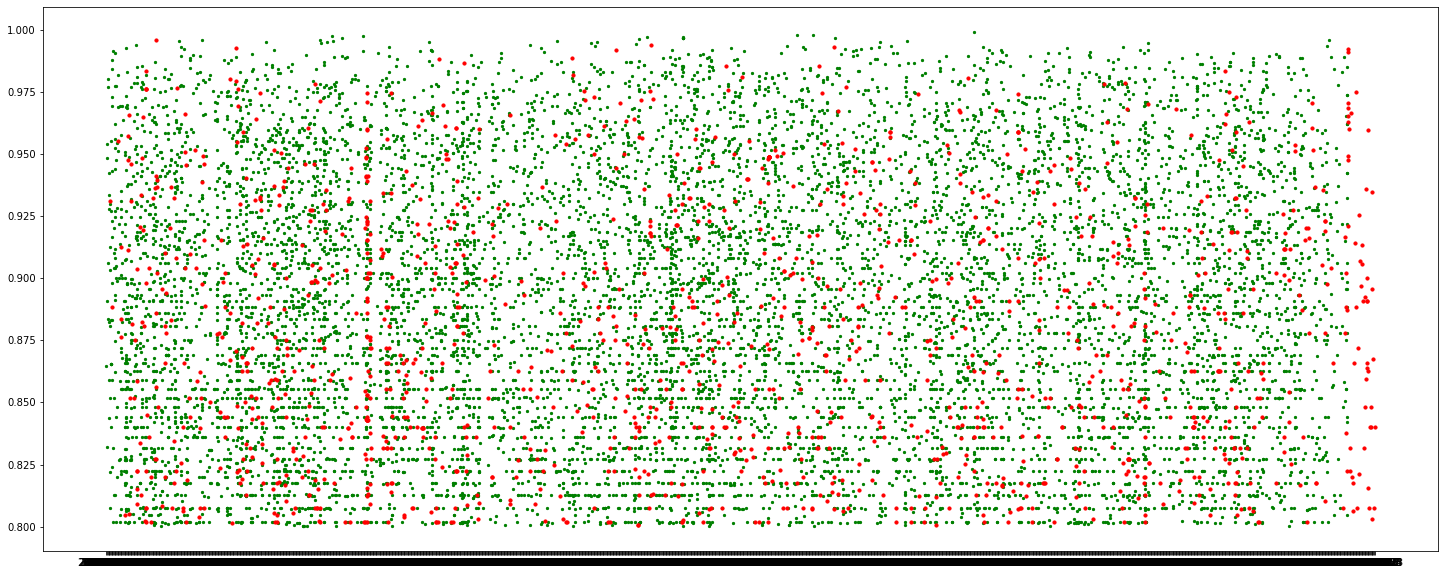

In [38]:
fig,ax = plt.subplots(figsize=(25,10))

cutoff_decimal = 0.8


pos_scores_df = sentiment_info_df_sorted[sentiment_info_df_sorted['compound'] > cutoff_decimal]
pos_scores = pos_scores_df['compound']
pos_dates = pos_scores_df['date_clean']

neg_scores_df = sentiment_info_df_sorted[sentiment_info_df_sorted['compound'] < -cutoff_decimal]
neg_scores = -neg_scores_df['compound']
neg_dates = neg_scores_df['date_clean']

ax.scatter(pos_dates, pos_scores, s=5, color='green')
ax.scatter(neg_dates, neg_scores, s=10, color='red')
plt.xticker()

In [30]:
# Try aggregate on weekly values, i.e. 7 days
# Based on how much they contribute increase size of scatter plot circle
agg_month_sentiment = []
agg_month_dates = []

for index, (idx, row) in enumerate(sentiment_info_df_sorted.iterrows()):
    date = row['date_clean']
    if index == 0:
        current_month = date[:7]
        current_size = 0

    tmp_month = current_month
    current_month = date[:7] # the seven first digits of the date
    if tmp_month != current_month:
        agg_month_sentiment.append(current_size)
        current_size = 0
        agg_month_dates.append(current_month)
    
    # updates weighted aggregated value of positive and negative
    current_size += row['compound'] #*row['numOccurrences']
    
    

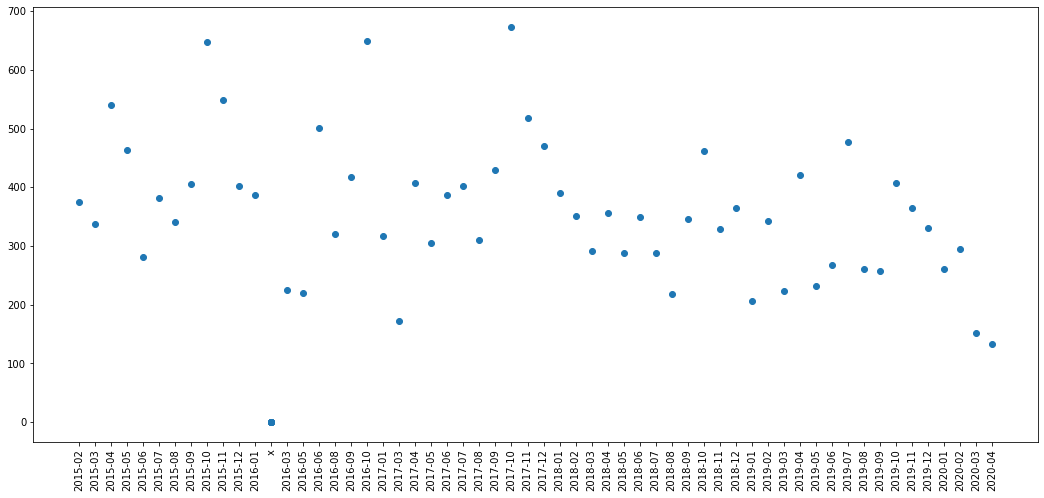

In [31]:
fig,ax = plt.subplots(figsize=(18,8))
result_values = []
result_mon = []
for mon, agg in zip(agg_month_dates, agg_month_sentiment):
    if agg > 100:
        result_values.append(agg)
        result_mon.append(mon)
    else:
        result_values.append(0)
        result_mon.append("x")
        

ax.scatter(result_mon, result_values)


#ax.plot(agg_month_dates, agg_month_sentiment)
plt.xticks(rotation=90);